# 1. Function Initialization

In [14]:
# Import necessary libraries
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pyvisa
import time
import sys
from pathlib import Path

# Set matplotlib to display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All dependency libraries imported successfully!")

All dependency libraries imported successfully!


In [ ]:
device_ip="127.0.0.1"
module_name = 'S2_M4901'
board_name = 'S0_M1210'
chs = ["CH1", "CH2"]
current_dir = Path.cwd()
Partner_Summit_path = current_dir / "Partner_Summit"
IP_ADDR="127.0.0.1::5555"
save_file_path = "/UserSpace"
show_data_nums = 2

In [16]:
visa_resource = f'TCPIP::{device_ip}::5555::SOCKET'
rm = pyvisa.ResourceManager('@py')

In [17]:
session = rm.open_resource(visa_resource)  # open resource
session.write_termination = '\n'
session.read_termination = '\n'
session.timeout = 50000  # timeout unit: ms
scpi_query = session.query
scpi_write = session.write
scpi_read = session.read

In [18]:
def start_single_wave():
    scpi_query(f':SYS:Control:RUN {module_name}')
    scpi_query(f':SAT:TRIGger:INTernal:Run {board_name}')

def stop_single_wave():
    scpi_query(f':SAT:TRIGger:INTernal:Stop {board_name}')
    scpi_query(f':SYS:Control:STOP {module_name}')

# 2. Get demo directory

In [19]:
original_list = os.listdir(Partner_Summit_path)
sorted_file_list = sorted(original_list, key=lambda x: int(x.split('_')[2].split('.')[0]), reverse=True)

In [20]:
for i, wave in enumerate(sorted_file_list): 
    # Create wave table
    wave_name = f"seg{i}"
    file_path = f"{Partner_Summit_path}/{wave}"
    file_obj = open(file_path, 'rb')
    file_len = os.path.getsize(file_path) # Total file length
    f_len = file_len//8
    file_obj.close()

    scpi_query(f':AWG:WAVList:ADDList {module_name},{wave_name},{f_len},Double')
    # Download waveform file to wave table
    data = {
        "scpi": f":AWG:WAVLIST:WAVeform:RTTRACE {module_name},{wave_name},0,{f_len},\n"
    }
    with open(file_path, 'rb') as f:
        files = {
            "file": f
        }
        response = requests.post(f'http://{device_ip}:8000/scpi', data=data, files=files)

In [21]:
# Create wave table
NSWave_name = "sequence1"
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

''

In [22]:
# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
sequence = f"""@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i in range(len(sorted_file_list)):
    sequence += f'    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, "seg{i}")\n'
sequence += "    while True:\n"
for i in range(len(sorted_file_list)):
    sequence += "        nw.wait_for_trigger_with_source(1)\n"
    sequence += f"        nw.play_arb(seg{i})\n"
sequence += '    return nw.Kernel()\n'  


nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc": sequence
}
print(sequence)

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, "seg0")
    seg1: nw.ArbWave = nw.init_arbwave(wlist, "seg1")
    seg2: nw.ArbWave = nw.init_arbwave(wlist, "seg2")
    seg3: nw.ArbWave = nw.init_arbwave(wlist, "seg3")
    seg4: nw.ArbWave = nw.init_arbwave(wlist, "seg4")
    seg5: nw.ArbWave = nw.init_arbwave(wlist, "seg5")
    seg6: nw.ArbWave = nw.init_arbwave(wlist, "seg6")
    seg7: nw.ArbWave = nw.init_arbwave(wlist, "seg7")
    seg8: nw.ArbWave = nw.init_arbwave(wlist, "seg8")
    seg9: nw.ArbWave = nw.init_arbwave(wlist, "seg9")
    seg10: nw.ArbWave = nw.init_arbwave(wlist, "seg10")
    seg11: nw.ArbWave = nw.init_arbwave(wlist, "seg11")
    seg12: nw.ArbWave = nw.init_arbwave(wlist, "seg12")
    seg13: nw.ArbWave = nw.init_arbwave(wlist, "seg13")
    seg14: nw.ArbWave = nw.init_arbwave(wlist, "seg14")
    seg15: nw.ArbWave = nw.init_arbwave(wlist, "seg15")
    seg16: nw.ArbWave = nw.init_arbwave(wlist, "seg16")
    seg17: nw.

In [23]:
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for ch in chs:
    scpi_query(f':AWG:NSQC:COMPile {ch},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

''

In [24]:
# Trigger source
scpi_query(f':DAQ:TRIGger:SOURce {module_name},Level')
src = scpi_query(f':DAQ:TRIGger:SOURce? {module_name},')
print(f'{module_name} trigger source is {src}')
# Amplitude trigger level
for ch in chs: 
    scpi_query(f':DAQ:TRIGger:EDGe:LEVel {ch},0.1')
    level = scpi_query(f':DAQ:TRIGger:EDGe:LEVel? {ch},')
    print(f'{ch} Trigger Level is {level}')

S2_M4901 trigger source is Level
CH1 Trigger Level is 0.09999
CH2 Trigger Level is 0.09999


In [25]:
for ch in chs:
    # Enable data saving to disk
    scpi_query(f':DAQ:UPSTream:SAVe:EN {ch},True')
    # Save path
    scpi_query(f':DAQ:UPSTream:SAVe:DIRectory {ch},{save_file_path}')

In [26]:
start_single_wave()
time.sleep(5)
stop_single_wave()

In [27]:
for ch in chs:
    # Disable data saving to disk to prevent storage overflow
    scpi_query(f':DAQ:UPSTream:SAVe:EN {ch},False')

In [28]:
# Data type mapping
data_type_map = {
    3: np.int8,
    5: np.int16,
    6: np.int16 # QI concatenation, each is int16
}
data_type_len_map = {
    np.int8: 1,
    np.int16: 2,
}

In [29]:
result_dir = current_dir / 'result' # Result save path
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [30]:
original_list = os.listdir(save_file_path)
# Remove 'WaveList' and 'NSQC'
filtered_list = [item for item in original_list if item not in ['WaveList', 'NSQC']]
# Sort by date and time in descending order (newest first)
sorted_list = sorted(filtered_list, reverse=True)

In [31]:
file_name = f'{save_file_path}/{sorted_list[0]}/CH1_0.data' # Raw data path

In [32]:
file_obj = open(file_name, 'rb')
head_length = 32 # Header length
file_len = os.path.getsize(file_name) # Total file length
read_len = 0 # File length already read

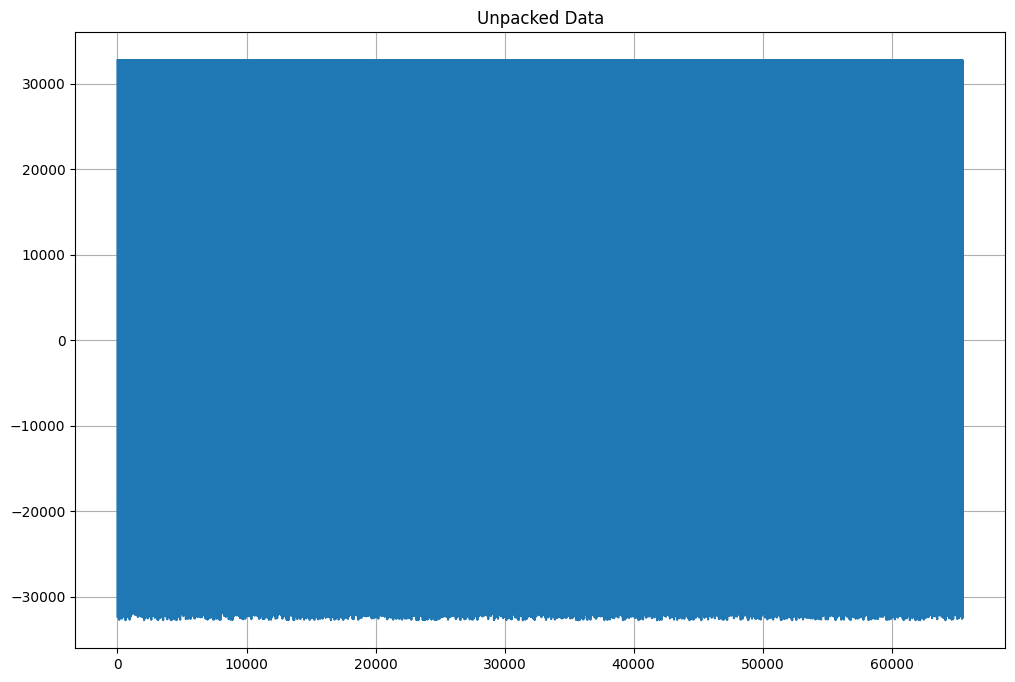

NO.0, prt: 0, read_len: 131104/43657632


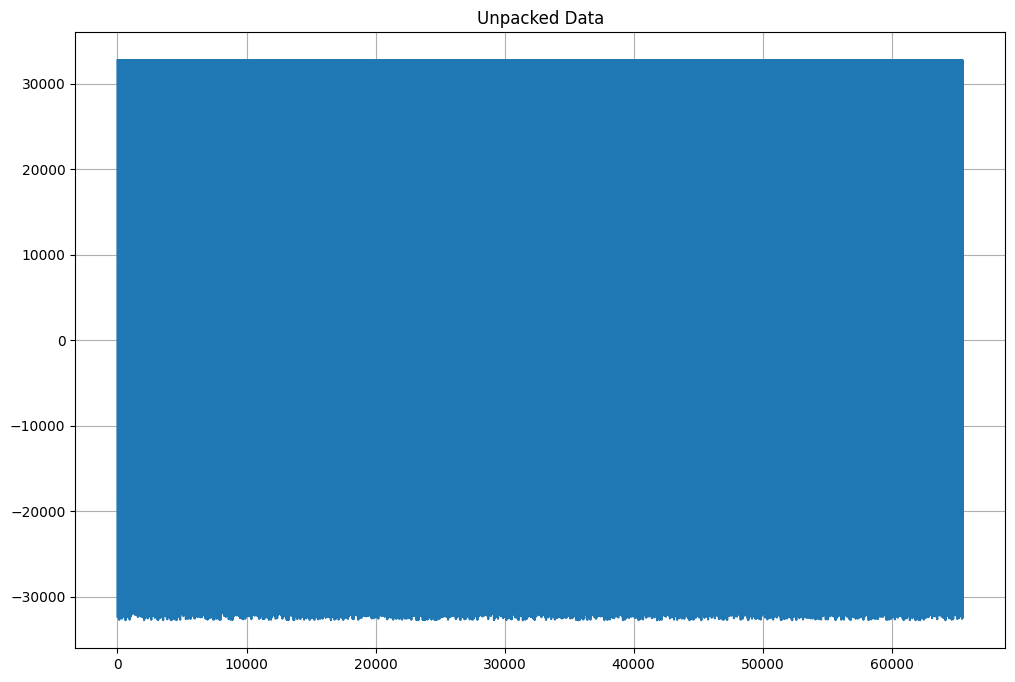

NO.1, prt: 1, read_len: 262208/43657632


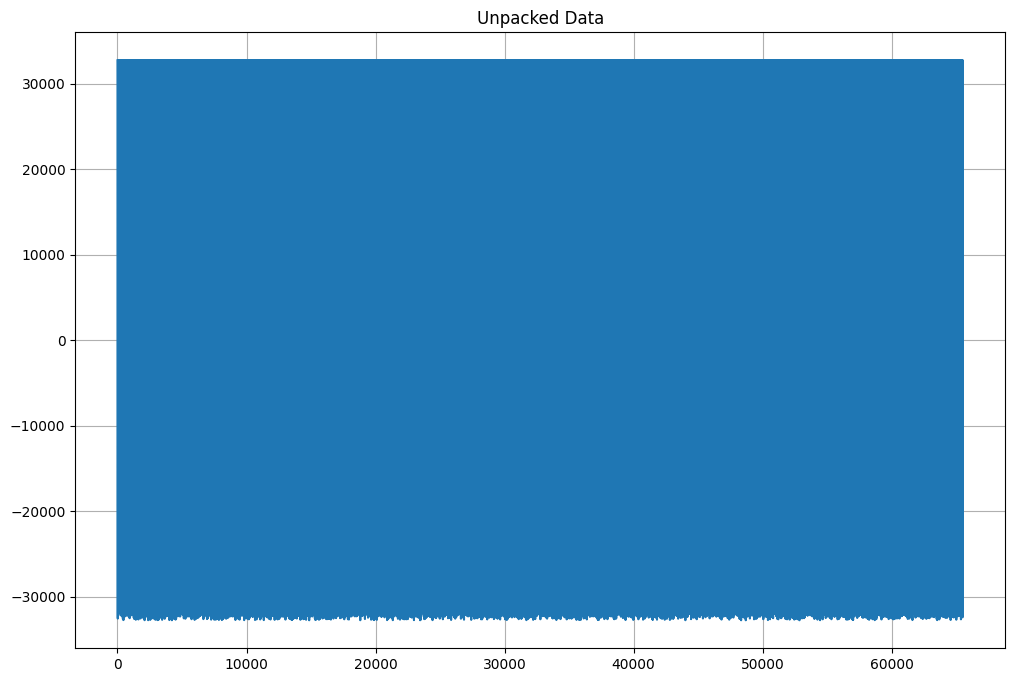

NO.2, prt: 2, read_len: 393312/43657632


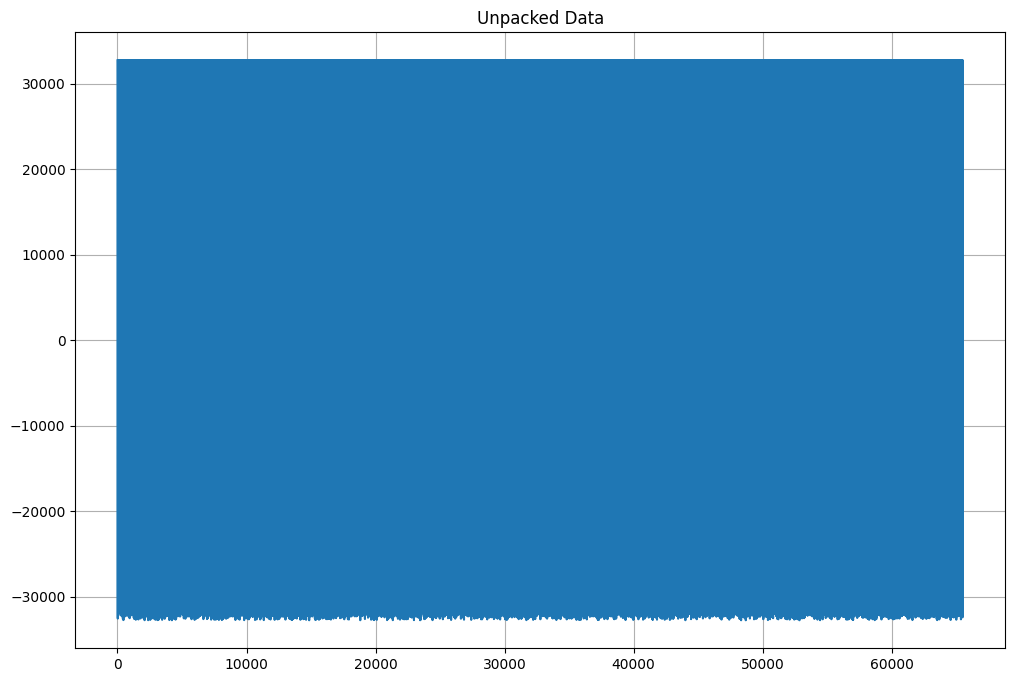

NO.3, prt: 3, read_len: 524416/43657632


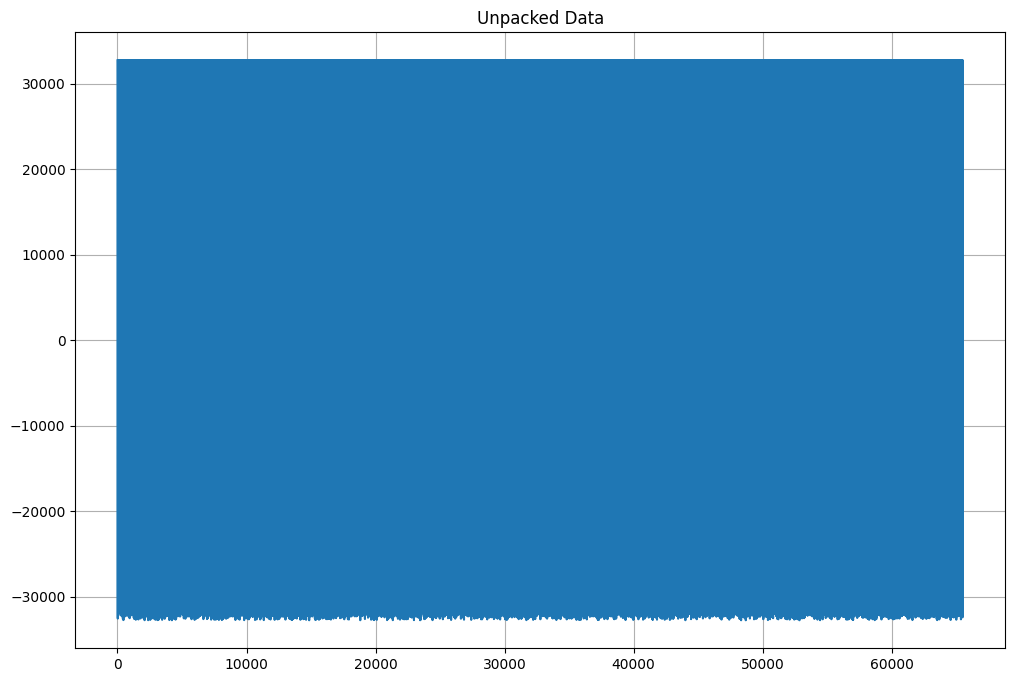

NO.4, prt: 4, read_len: 655520/43657632


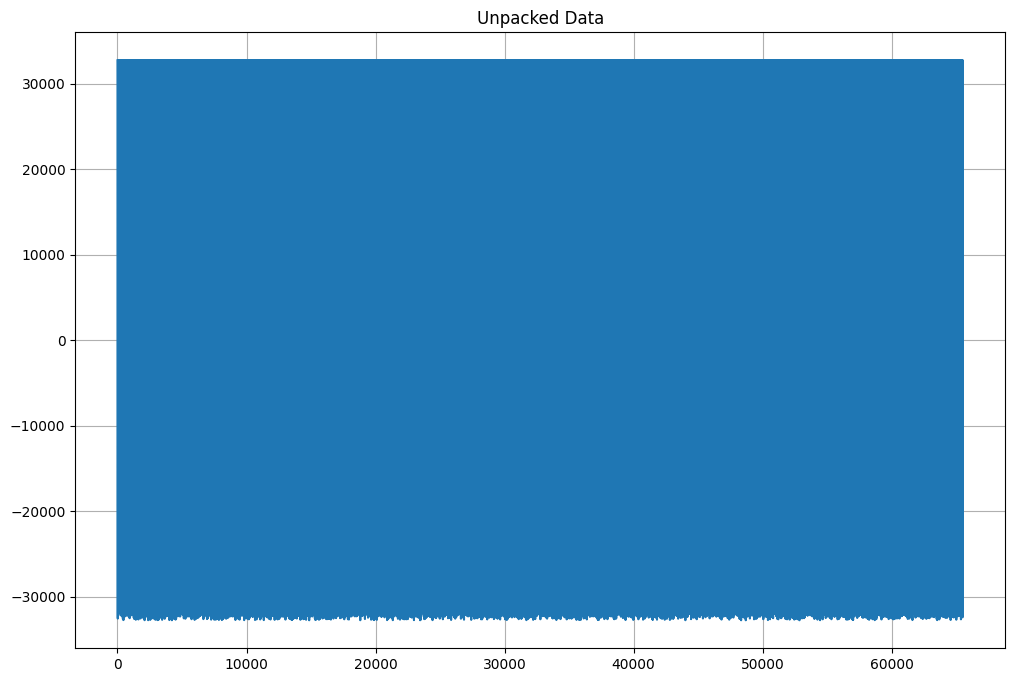

NO.5, prt: 5, read_len: 786624/43657632


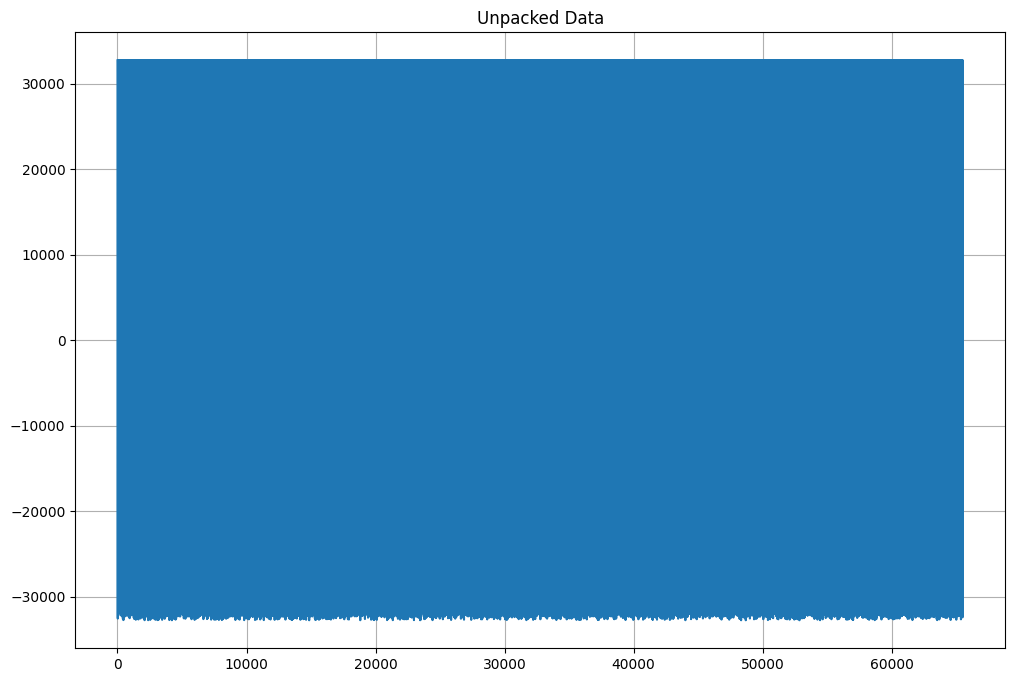

NO.6, prt: 6, read_len: 917728/43657632


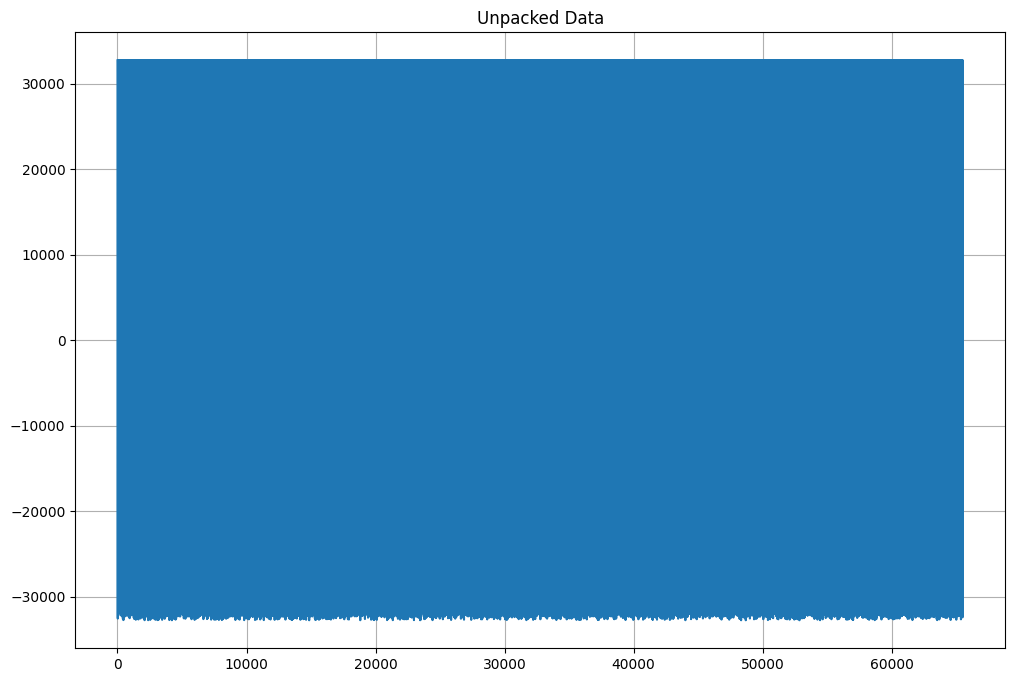

NO.7, prt: 7, read_len: 1048832/43657632


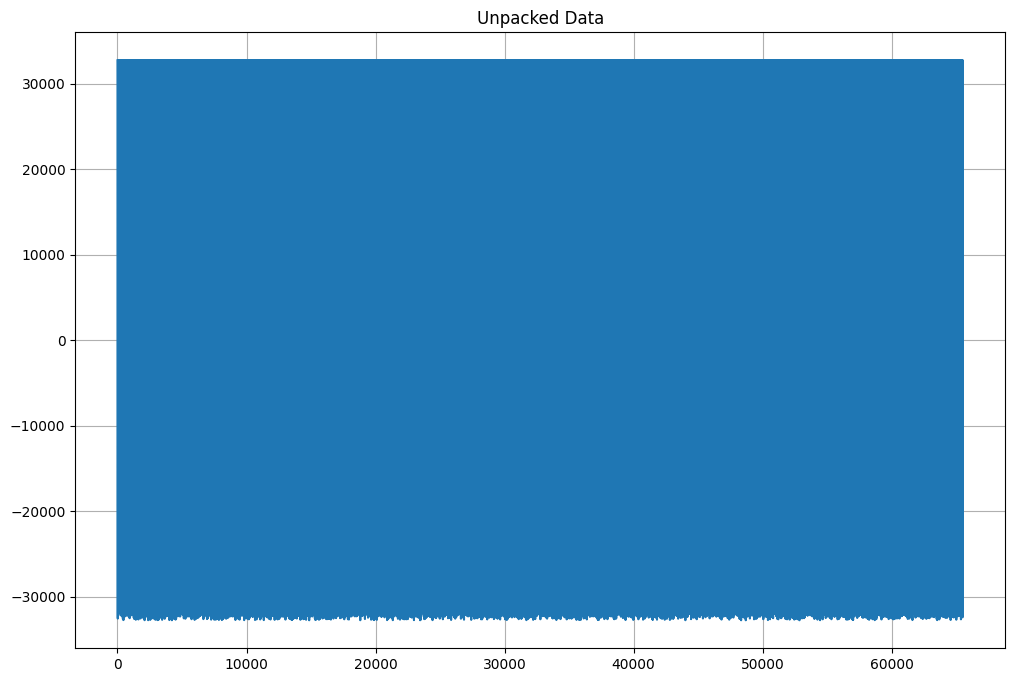

NO.8, prt: 8, read_len: 1179936/43657632


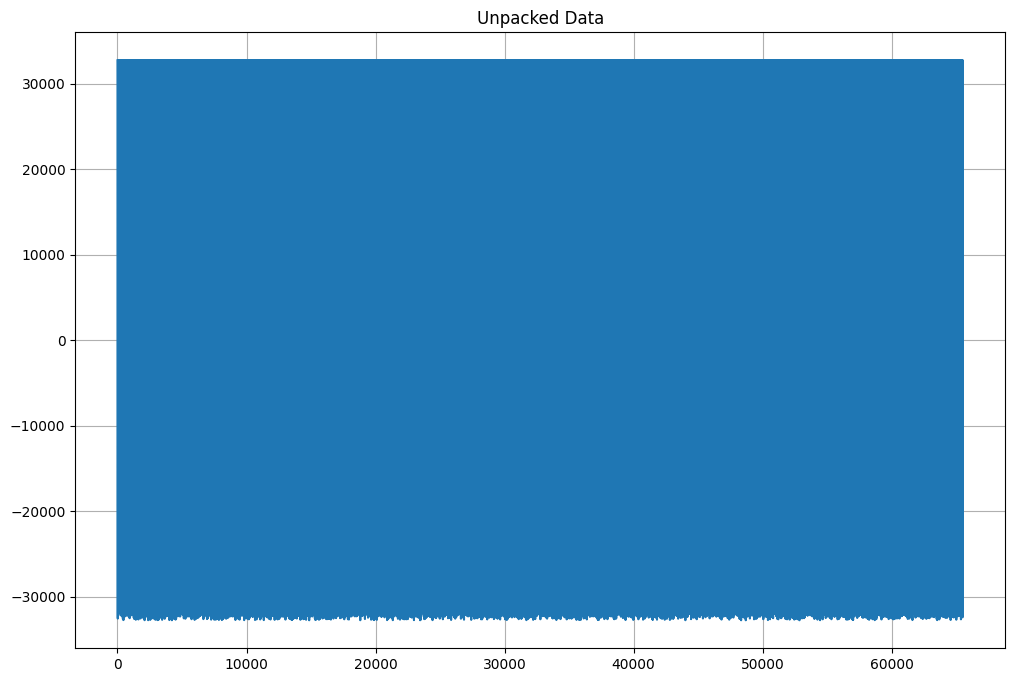

NO.9, prt: 9, read_len: 1311040/43657632


In [33]:
for i in range(show_data_nums):
    head_data = file_obj.read(head_length) # Read header
    read_len += head_length
    pack_length = np.frombuffer(head_data[8:12], dtype=np.uint32)[0] # Packet length
    data_length = pack_length - head_length # Data length
    read_len += data_length
    data_type = np.frombuffer(head_data[24:25], dtype=np.int8)[0] # Data type
    data_type = data_type_map.get(data_type, np.int16) # Data type mapping
    prt = np.frombuffer(head_data[4:8], dtype=np.uint32)[0] # Packet count
    data = np.frombuffer(file_obj.read(data_length), dtype=data_type) # Data
    plt.plot(data)
    plt.title('Unpacked Data')
    plt.grid(True)
    plt.show()
    plt.savefig(f'{result_dir}/unpacked_data_{prt}.png')
    plt.close()
    print(f"NO.{i}, prt: {prt}, read_len: {read_len}/{file_len}")
    if read_len >= file_len:
        break
file_obj.close()